In [39]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

$r_{ij} = r_i - r_j$
$$
U(r_{ij}) = 4\varepsilon [(\sigma/r_{ij})^{12} - (\sigma/r_{ij})^6] \\
U^*(r_{ij}) = 4[(r_{ij}^*)^{-12} - (r_{ij}^*)^{-6}] \\
\phantom{U^*(r_{ij})} = 4[(r_{ij}^*)^{-6} - 1](r_{ij}^*)^{-6} \\
$$
Force atom $j$ exerts on $i$
$$
\vec{F}^*(r_{ij}) = 48[(r_{ij}^*)^{-6} - 0.5](r_{ij}^*)^{-8} \vec{r_{ij}^*} \\
$$

21.213203435596423


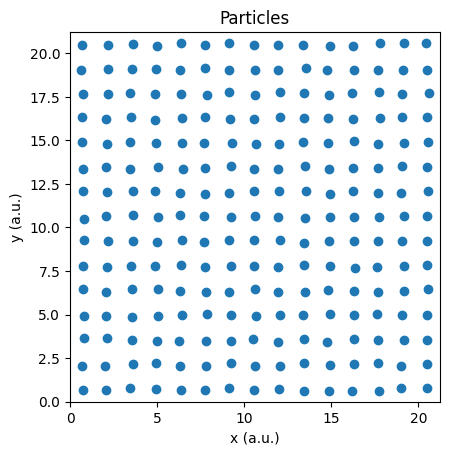

In [40]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

X_U_MIN = 2**(1/6)*1
N_L = 15
N = N_L*N_L
DIM = 2

DENSITY = 0.5
LINEAR_DENSITY = DENSITY**(1/DIM)
L = N_L / LINEAR_DENSITY
print(L)

def generate_square_lattice(l,n):
    step = l / n
    # generate matrices of lattice coordinates
    rmat = np.meshgrid(*[np.arange(0,l,step)+step/2 for i in range(DIM)])
    # convert matrices of x and y positions to vectors of x and y positions, and return
    return np.vstack(list(map(np.concatenate,rmat)))

# generate lattice positions
r = generate_square_lattice(L,N_L)
# add small random displacements
r += np.random.uniform(-0.1,0.1,r.shape)

V_SPREAD = 5
v = rng.normal(0, V_SPREAD, (DIM,N))

plt.title("Particles")
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r)
plt.show()

testing with r as [xs, ys]
[ 5. 13. 25.]
[-0.03174119 -0.00181703 -0.00025317]
[[0.0377856  0.00167908 0.0001843 ]
 [0.0755712  0.00251863 0.00024573]]

testing with r as [x matrix, y matrix]
[[ 5. 10. 17.]
 [ 8. 13. 20.]
 [13. 18. 25.]]
[[-0.03174119 -0.00399319 -0.00081119]
 [-0.00779443 -0.00181703 -0.00049713]
 [-0.00181703 -0.00068294 -0.00025317]]
[[[0.0377856  0.0023952  0.00028724]
  [0.01167297 0.00167908 0.00029992]
  [0.00251863 0.00068564 0.0001843 ]]

 [[0.0755712  0.0071856  0.00114894]
  [0.01167297 0.00251863 0.00059985]
  [0.00167908 0.00068564 0.00024573]]]


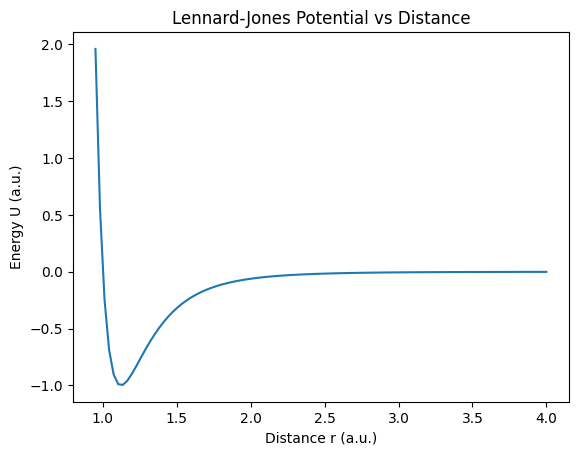

In [41]:
def magnitude2(x):
    return (x*x).sum(axis=0)

def pair_U_lj(x):
    return 4*(x**-6 - 1)*x**-6

U_CUTOFF = pair_U_lj(L/2)

def pair_U_lj_vec(r):
    r2 = magnitude2(r)
    return 4*(r2**-3 - 1)*r2**-3 - U_CUTOFF

def pair_F_lj_vec(r):
    r2 = magnitude2(r)
    return -48*(r2**-3 - 0.5)*r2**-4 * r

print("testing with r as [xs, ys]")
rtest = np.array([[1,2,3],[2,3,4]], dtype=float)
print(magnitude2(rtest))
print(pair_U_lj_vec(rtest))
print(pair_F_lj_vec(rtest))

print()
print("testing with r as [x matrix, y matrix]")
rmat = np.array([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[2,3,4],[2,3,4],[2,3,4]],
], dtype=float)
print(magnitude2(rmat))
print(pair_U_lj_vec(rmat))
print(pair_F_lj_vec(rmat))

x = np.linspace(0.95,4,100)
plt.plot(x,pair_U_lj(x))

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.show()


-2.139845508043354
(2, 225, 225)
(2, 225)


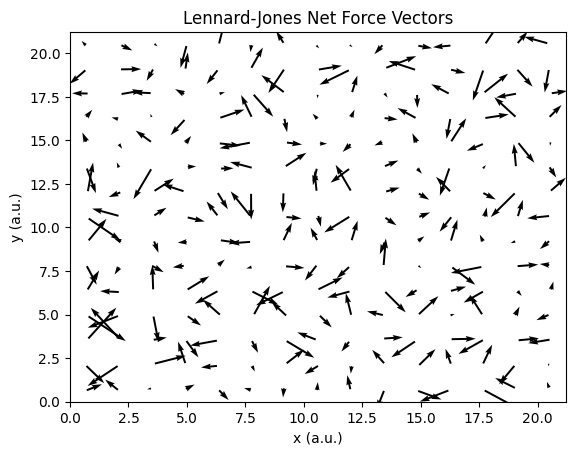

In [42]:
x = r[0]
def pair_displacements_1D(x):
    x = -np.diff(np.meshgrid(x,x),axis=0)[0]
    x = (L/2+x)%L-L/2
    return x

def pair_displacements(r):
    return np.array([pair_displacements_1D(x) for x in r])

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r)

diag_mask = np.identity(N,dtype=int)==1

Us = pair_U_lj_vec(displacements)
Us[diag_mask] = 0
U = Us.sum()
U_av = U / N
print(U_av)

F_lj = pair_F_lj_vec(displacements)
F_lj[:,diag_mask] = 0
print(F_lj.shape)
F_net = F_lj.sum(axis=2)
print(F_net.shape)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces,magnitudes(lj_forces))
# plt.show()

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,magnitudes(displacements))
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(0, L)
# plt.ylim(0, L)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,1),
# )
# plt.colorbar()
# plt.text(L*0.1,L*0.1, "Forces are clipped with upper bound 1")
# plt.show()

plt.title("Lennard-Jones Net Force Vectors")
plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.quiver(*r, *F_net, angles="xy", )
plt.show()

In [43]:
class Calculate():
    def U_av(r):
        global N
        displacements = pair_displacements(r)
        Us = pair_U_lj_vec(displacements)
        Us[diag_mask] = 0
        return Us.sum() / N

    def F_lj(r):
        global N
        displacements = pair_displacements(r)
        diag_mask = np.identity(N,dtype=int)==1

        lj_forces = pair_F_lj_vec(displacements)
        lj_forces[:,diag_mask] = 0
        net_lj_force = lj_forces.sum(axis=2)
        return net_lj_force

    def a(r):
        return Calculate.F_lj(r)

def velocity_verlet(r,v,dt):
    a1 = Calculate.a(r)
    r = r + v*dt + a1/2 * dt**2
    a2 = Calculate.a(r)
    v = v + (a1+a2)/2*dt
    return r,v

def wall_boundary_conds(r,v):
    v *= 1 - (np.heaviside(r-L,0) * np.heaviside(v,0))*2
    v *= 1 - (np.heaviside(-r,0) * np.heaviside(-v,0))*2
    return r,v

def periodic_boundary_wrap(r,v):
    r %= L
    return r,v

def boundary_conds(r,v):
    return periodic_boundary_wrap(r,v)

def step_state(r,v,dt):
    r,v = velocity_verlet(r,v,dt)
    r,v = boundary_conds(r,v)
    return r,v

In [44]:
def time_evolution(r,v,steps,dt):
    rs = np.zeros((steps,r.shape[0], r.shape[1]))
    vs = np.zeros((steps,r.shape[0], r.shape[1]))
    for i in range(steps):
        rs[i], vs[i] = step_state(r,v,dt)
    return rs, vs

In [45]:
t_total,dt = 10,0.001
steps = int(t_total//dt)
rs, vs = time_evolution(r,v,steps,dt)

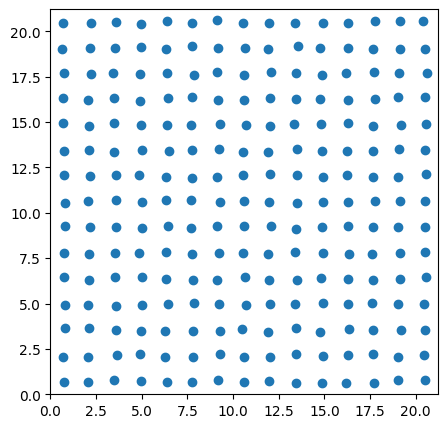

In [46]:
ANIMATE = True
if ANIMATE:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    points = ax.scatter(*rs[0])

    k = int(0.01//dt)
    nframes = steps // k

    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    def animation_frame(i):
        points.set_offsets(rs[i*k].T)

    lj_anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
    lj_anim.save("test.gif", writer="pillow", fps=30, dpi=100)

In [47]:
t = np.arange(steps)*dt
KE_t = (vs**2).sum(axis=(1,2))/N/2
U_t = np.array([Calculate.U_av(r) for r in rs])

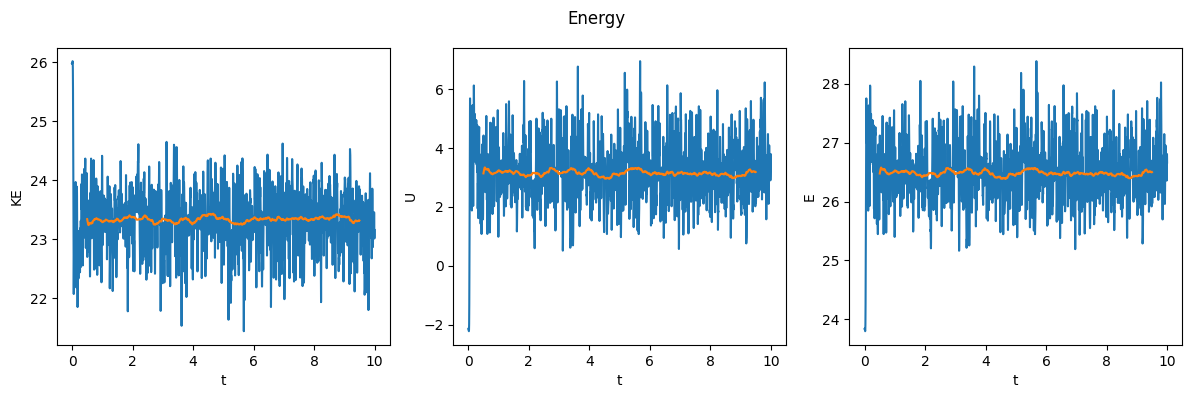

In [48]:
def window(size):
    return np.ones(size)/float(size)
WLEN = 1000

fig,(ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(t,KE_t)
ax1.plot(t[WLEN//2:-WLEN//2], np.convolve(KE_t, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax1.set_ylabel("KE")
ax1.set_xlabel("t")

ax2.plot(t,U_t)
ax2.plot(t[WLEN//2:-WLEN//2], np.convolve(U_t, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax2.set_ylabel("U")
ax2.set_xlabel("t")

E_t = KE_t + U_t
ax3.plot(t,E_t)
ax3.plot(t[WLEN//2:-WLEN//2], np.convolve(E_t, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax3.set_ylabel("E")
ax3.set_xlabel("t")

fig.suptitle("Energy")
fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

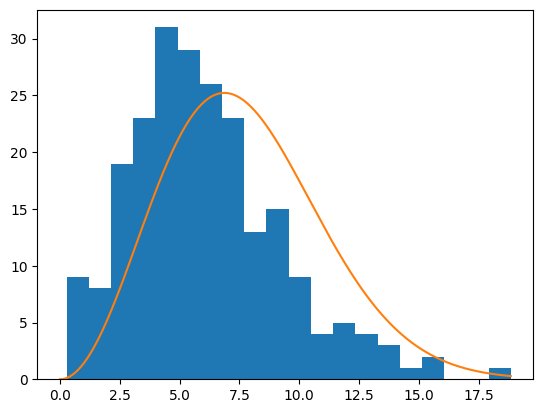

In [52]:
T = KE_t[-WLEN//2]
D = lambda v: (2*np.pi*T)**(-3/2) * 4*np.pi*v**2 * np.exp(-v**2/(2*T))

v_abs = np.sqrt((vs[-WLEN//2]**2).sum(axis=0))
v_range = np.linspace(0,v_abs.max(),1000)

fig, ax = plt.subplots()
# ax.hist(v_abs)
counts, bins = np.histogram(v_abs, bins=20)
ax.stairs(counts, bins, fill=True)
ax.plot(v_range, D(v_range)*N * (bins[1]-bins[0]))
fig.show()